# Shor's Algorithm


Integer factorization [[1](#IntegerFactor)] is a famous problem in number theory: given a composite number $N$, find its prime factors. The importance of the problem stems from there being no known efficient classical algorithm (in the number of bits needed to represent $N$ in polynomial time), and much of modern-day cryptography relies on this fact. In 1994, Peter Shor came up with an efficient _quantum_ algorithm for the problem [[2](#Shor94)]; providing, arguably, the most important evidence for an exponential advantage of quantum computing over classical computing.

### Full Algorithm

Shor's algorithm consists of a classical part and a quantum subroutine. The steps of the algorithm for factoring an input number $N$, summarized from [[3](#ShorSteps)]:

1. Pick a random number $1 < a < N$ that is co-prime with $N$. Check co-primality by computing the GCD (greatest common divisor) of $a$ and $N$. If it is 1, then we have a co-prime $a$; otherwise, we have a non-trivial factor of $N$ and we are done.
2. Find the period $r$ of the following function, using the quantum period finding algorithm (described in [[3](#ShorSteps)]): $$f(x) = a^x\hspace{-8pt} \mod \hspace{-4pt} N$$
3. If $r$ is odd or $a^{r/2} = -1 \mod N$, return to step 1 (this event can be shown to happen with probability at most $1/2$).
4. Otherwise, $\gcd(a^{r/2} \pm 1, N)$ are both factors of $N$, and computing one of them yields the required result.


### Quantum Period Finding

The quantum part of Shor's algorithm—the period finding—is quantum phase estimation (QPE) applied to the unitary $U$, which computes multiplication by $a$ modulo $N$: $U|y\rangle =|ya \hspace{-6pt}\mod \hspace{-4pt} N\rangle$[[4](#NielsenChuang)]. This unitary is applied to the input state $|y=1\rangle$, which is an equal superposition of $r$ eigenstates of $U$ ($r$ being the period we wish to find) with eigenvalues 
$\exp (2\pi i s/r)$,  $s = 0, ... ,r-1$. The measured output of the QPE circuit is therefore a number that is a good approximation to $s/r$ for some $s < r$. The denominator $r$ can be found with some additional classical postprocessing [[4](#NielsenChuang)]. 
The repeated applications of $U^{2^{j}}$ in the QPE algorithm are realized by multiplying with the corresponding powers $a^{2^{j}}$ modulo $N$. The resulting computation (of the repeated multiplications) is exponentiation modulo $N$. The general scheme of the QPE realizing the quantum order finding is shown in this figure:


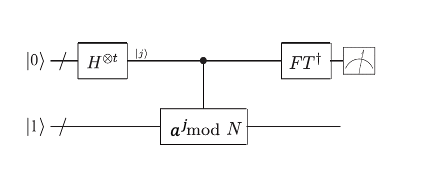

The above QPE scheme includes three components: 

* A Hadamard transform applied to a first $t=2n$ qubit register at the begining of the circuit ($t$ is set by the required accuracy and probability of success [[4](#NielsenChuang)])
* An inverse QFT applied to the same register at the end 
* A modular exponentiation applied to the first and a second $n$ qubit register, computing $a^{j}\hspace{-6pt}\mod \hspace{-4pt} N$ for each of the $j$ values in the first register

The most difficult component to implement is the modular exponentiation, which requires additional auxiliary qubits. 
Here, we construct a circuit implementing the above period finding algorithm, receiving classical numbers $N$ and $a$ as input and returning (with a good probability) a measured output, which is a good approximation to the rational number $s/r$ above.    
We start with modular addition, going via modular multiplication, to modular exponentiation and the full period finding circuit. The modular adder used here is a version of the QFT-based addition of Draper [[5](#Draper)] and is similar to the circuit suggested in [[6](#Beauregard)]. More generally, the period finding circuit here is similar to implementation of [[6](#Beauregard)] except for the fact that the modular exponentiation and the Quantum Fourier Transform (QFT) at the end are realized on a full register of $2n$ qubits (not on a single qubit as in [[6](#Beauregard)]) and the circuit therefore includes $4n+2$ qubits.   

## Modular Addition
The basic building block in the modular exponentiation function is the doubly controlled modular adder in the Fourier space. This circuit relies on adders in the Fourier space, which add a classical number $a$ to a quantum register, and consist solely of single qubit phase gates as shown in the figure [[6](#Beauregard)]:

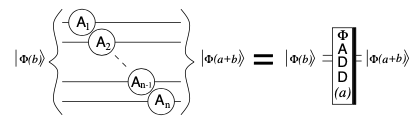

The modular adder calculates $|\phi(b)\rangle \rightarrow |\phi(b+a)\hspace{-8pt}\mod N\rangle$ where $|\phi(b)\rangle = QFT|b\rangle$ is the input to the circuit and $a$ and $N$ are classical values hardwired into the circuit (specifically into the phases of the adder and inverse adder circuits). The input $|\phi(b)\rangle$ $(b < N)$ is encoded into an $n+1$ qubit register where $n$ is the size of $N$ such that the most significant bit of the register is an overflow bit, which is zero at the input and the output of the circuit. The circuit includes three adder functions and two inverse adders (subtractors) in the Fourier space as shown in the figure [[6](#Beauregard)]. (The thick bar on the right/left denotes an adder/inverse adder.) 


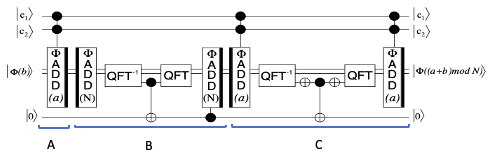

Dividing the circuit into three subcircuits and assuming that both control qubits are in state $|1\rangle$, the state evolves as follows:

- In subcircuit A, the value $a$ is added to $b$, that is $|\phi(b)\rangle \rightarrow |\phi(a+b)\rangle$. 
- In subcircuit B, $N$ is subtracted from $a+b$ and then added again if $N < a+b$. This is done by checking the MSB of $\phi(a+b)$, which is in the state $|1\rangle$ iff $N < a+b$. The value of the MSB is checked by applying inverse QFT to the b-register, copying the state of the MSB to an auxiliary qubit, and conditioning the addition of $N$ on the auxiliary qubit.
- In subcircuit C, the auxiliary qubit is reset to $|0\rangle$, disentangling it from the b-register. This is done by first subtracting $a$ from the b-register, checking the MSB, flipping the auxiliary qubit if the MSB is in state $|0\rangle$, and re-adding $a$ to the register.

We define a QFT function without swap gates. In subcircuits B and C above there is no need to introduce swap gates (required for keeping the order of the qubits in a register). We keep track of the MSB (which, after the QFT, is at the LSB position) and apply the CNOT gate to the 'correct' qubit. The order reverses again after the application of the second QFT in each circuit. In other QFT functions (used later in modular multiplication and at the end of the circuit) we keep the swap gates for clarity.



In [ ]:
import math

from classiq import (
    CPHASE,
    PHASE,
    CInt,
    Constraints,
    H,
    Output,
    Preferences,
    QArray,
    QBit,
    X,
    allocate,
    create_model,
    execute,
    hadamard_transform,
    invert,
    qft,
    qfunc,
    repeat,
    show,
    synthesize,
    write_qmod,
)
from classiq.qmod.symbolic import pi


@qfunc
def my_qft_step(qbv: QArray[QBit]) -> None:
    H(qbv[0])
    repeat(
        count=qbv.len - 1,
        iteration=lambda index: CPHASE(pi / 2 ** (index + 1), qbv[0], qbv[index + 1]),
    )


# qft without SWAP gates
@qfunc
def qft_ns(qbv: QArray[QBit]) -> None:
    repeat(
        count=qbv.len,
        iteration=lambda index: my_qft_step(qbv[index : qbv.len]),
    )

The `ccmod_add` function implements the modular adder, which adds the (classical) number $a$ to the b-register modulo $N$ in the QFT space. The function receives $a$ and $N$ as `CInt`s: classical integer parameters. The uncontrolled, controlled, and doubly controlled adders in the QFT space are implemented by the `phase_lad` function. The function that checks the MSB of the b-register and conditionally flips the auxiliary qubit is `check_msb`. Because we do not use SWAP after the QFT, the MSB is the first qubit at this stage.

In [2]:
from classiq.qmod import QNum, bind, control, within_apply
from classiq.qmod.builtins.classical_functions import qft_const_adder_phase


def get_adder_phase(bit_index, value, reg_len):
    """
    Calculates the required phase for the QFT adder.
    """
    bit_array = [int(bit) for bit in bin(value)[2:].zfill(reg_len)]
    return sum(
        2 * math.pi / (2 ** (pos_index + 1))
        for pos_index in range(reg_len - bit_index)
        if bit_array[bit_index + pos_index]
    )


@qfunc
def phase_lad(
    value: int,
    phi_b: QArray[QBit],
) -> None:
    for index in range(phi_b.len):
        PHASE(theta=get_adder_phase(index, value, phi_b.len), target=phi_b[index])


@qfunc
def ctrl_x(ref: CInt, ctrl: QNum, aux: QBit) -> None:
    control(ctrl == ref, lambda: X(aux))


@qfunc
def check_msb(ref: CInt, x: QArray[QBit], aux: QBit) -> None:
    within_apply(lambda: invert(lambda: qft_ns(x)), lambda: ctrl_x(ref, x[0], aux))


@qfunc
def ccmod_add(
    N: int,
    a: int,
    phi_b: QArray[QBit],  # b in fourier basis
    c1: QBit,
    c2: QBit,
) -> None:
    ctrl = QArray()
    aux = QBit()

    within_apply(
        lambda: [allocate(1, aux), bind([c1, c2], ctrl)],
        lambda: [
            control(ctrl, lambda: phase_lad(a, phi_b)),
            invert(lambda: phase_lad(N, phi_b)),
            check_msb(1, phi_b, aux),
            control(aux, lambda: phase_lad(N, phi_b)),
            within_apply(
                lambda: invert(lambda: control(ctrl, lambda: phase_lad(a, phi_b))),
                lambda: check_msb(0, phi_b, aux),
            ),
        ],
    )

To check the modular addition circuit, we create a main function that includes `ccmod_add` between a QFT at the beginning and an inverse QFT at the end. We set the classical input to the modulo number (15) and the classical value to add (9), and set the input state of the b-register by applying X-gates to chosen qubits. (Here, we flipped the fourth qubit so the value of the register is 8.)

In [3]:
modulo_num_1 = 15
reg_len_1 = math.ceil(math.log(modulo_num_1, 2)) + 1
a_num_1 = 9

b_initial_value = 8


@qfunc
def main(b: Output[QNum], ctrl: Output[QArray[2]]) -> None:
    allocate(reg_len_1, b)
    allocate(2, ctrl)

    # set initial values for the addition
    b ^= b_initial_value
    X(ctrl[0])
    X(ctrl[1])

    # perform the addition in fourier basis and then transform back
    within_apply(
        lambda: qft(b), lambda: ccmod_add(modulo_num_1, a_num_1, b, ctrl[0], ctrl[1])
    )


qmod_1 = create_model(main)
write_qmod(qmod_1, "doubly_controlled_modular_adder", symbolic_only=False)

Once we have created a model of the circuit, we can synthesize it and view the circuit:

In [4]:
qprog_1 = synthesize(qmod_1)
show(qprog_1)

Quantum program link: https://platform.classiq.io/circuit/2wJRvjpaTxYxd5xDQzdIujacz0H?login=True&version=0.76.0


We now can execute the synthesized circuit on a simulator (we use the default simulator) and check the outcome:

In [5]:
result_1 = execute(qprog_1).result_value()
print(result_1.parsed_counts)

[{'b': 2, 'ctrl': [1, 1]}: 2048]


As expected, the value of the b-register is $2=8+9 \hspace{-4pt}\mod \hspace{-3pt}15$.

## Modular Multiplication
A controlled modular multiplication circuit that receives $b$ (in the b-register) as input and $x$ in additional x-register and outputs $|(b+xa) \hspace{-8pt}\mod \hspace{-4pt} N\rangle$ comprises repeated application of the doubly controlled modular adder, adding $2^{i}a$ for $i=0,...,n-1$ where one of the controls in each of the modular adders is the suitable qubit of the x-register, as in the following figure [[6](#Beauregard)].

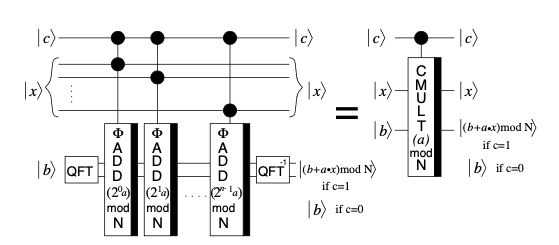

The `cmod_mult` function implements the above circuit.

In [6]:
@qfunc
def cmod_mult(
    N: int,
    a: int,
    b: QArray[QBit],
    x: QArray[QBit],
    ctrl: QBit,
) -> None:
    within_apply(
        lambda: qft(b),
        lambda: [
            ccmod_add(N, (a * (2**index)) % N, b, x[index], ctrl)
            for index in range(x.len)
        ],
    )

The above circuit outputs the state $|(b+xa)\hspace{-8pt}\mod \hspace{-3pt}N\rangle$ in the b-register (assuming the control is in state $|1\rangle$); however, the required output is $|xa \mod N\rangle$. This output can be obtained by conditionally swapping the b and x registers and applying the inverse of the modular multiplication circuit for the $a^{-1} \mod N$ classical value with input $b=0$, as in the following construction [[6](#Beauregard)].
  

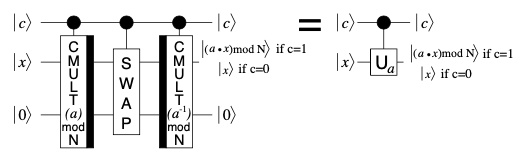

After the swap, the x and b registers are in the state $|ax\hspace{-6pt} \mod \hspace{-4pt}N\rangle|x\rangle$ and the inverse multiplication function (by $a^{-1}$) sends them to the state 
$|ax\hspace{-6pt} \mod\hspace{-4pt} N\rangle|x- a^{-1}ax\rangle = |ax \hspace{-6pt}\mod \hspace{-3pt} N\rangle|0\rangle$. Thus, the x-register carries the required output while the state of the b-register is $|0\rangle$ at the output. The `cmod_mult_pair` function implements this circuit using the `c_swap` and `creg_swap` functions, which implement the swap between qubits and registers, respectively.    

In [7]:
from sympy import mod_inverse

from classiq.qmod import SWAP, free
from classiq.qmod.symbolic import min


@qfunc
def multi_swap(x: QArray[QBit], y: QArray[QBit]) -> None:
    repeat(
        count=min(x.len, y.len),
        iteration=lambda index: SWAP(x[index], y[index]),
    )


@qfunc
def cmod_mult_pair(
    N: int,
    a: int,
    x: QArray[QBit],
    ctrl: QBit,
) -> None:
    b = QArray("b")
    allocate(x.len + 1, b)

    cmod_mult(
        N,
        a,
        b,
        x,
        ctrl,
    )
    control(ctrl, lambda: multi_swap(x, b))
    invert(
        lambda: cmod_mult(
            N,
            mod_inverse(a, N),
            b,
            x,
            ctrl,
        )
    )
    free(b)

## Modular Exponentiation
The above circuit can be applied repeatedly to achieve modular exponentiation. Specifically, taking an $m$ qubit $pow$ register (carrying value $M$) and applying the `cmod_mult_pair` function $m$ times in sequence cascading the control over the qubits of m-register multiplying by values $a^{2^{0}}, ..., a^{2^{m-1}}$ will take the input state $|M\rangle_{pow}|1\rangle_{x}|0\rangle_{b}$ to the output state $|M\rangle_{pow}|a^{M}\hspace{-6pt}\mod \hspace{-3pt} N\rangle_{x}|0\rangle_{b}$ as required (for clarity subscripts were added to identify the registers). The `mod_exp_fuc` below accepts the classical numbers $N$ and $a$ and implements the modular exponentiation.

In [8]:
@qfunc
def mod_exp_func(
    N: int,
    a: int,
    x: QArray[QBit],
    pow: QArray[QBit],
) -> None:
    for index in range(pow.len):
        cmod_mult_pair(N, (a ** (2**index)) % N, x, pow[index])

## Implementing Quantum Period Finding
Using the modular exponentiation function, it is straightforward to implement the complete period finding algorithm. We apply the Hadamard transform to the $pow$ register at the beginning of the circuit and an inverse QFT at the end. In the following example we apply the period finding algorithm to find the period of $a=11$ modulo $N=21$ from which we obtain the factors of $21$.

In [9]:
modulo_num = 21  # The number we wish to factor
x_len = math.ceil(math.log(modulo_num, 2))
a_num = 11  # Should be coprime with modulo_num


@qfunc
def main(
    x: Output[QNum],
    pow: Output[QNum],
) -> None:
    allocate(x_len, x)
    allocate(2 * x_len, pow)

    hadamard_transform(pow)
    x ^= 1

    mod_exp_func(
        modulo_num,
        a_num,
        x,
        pow,
    )
    invert(lambda: qft(pow))

In [10]:
max_circuit_width = 4 * x_len + 2
qmod_2 = create_model(
    entry_point=main,
    constraints=Constraints(max_width=max_circuit_width),
    preferences=Preferences(optimization_level=1),
)
write_qmod(qmod_2, "shor", symbolic_only=False)

qprog_2 = synthesize(qmod_2)
show(qprog_2)

Quantum program link: https://platform.classiq.io/circuit/2wJSEZxGRP4tpGCwHNbgTA0xpMa?login=True&version=0.76.0


### Output Values for 2048 Shots
Let us first examine the $x$ register, which keeps a superposition of values $a^j$ for all possible values of $j$. 
Namely, $11^{y}\hspace{-6pt}\mod \hspace{-3pt}N$ for $y=0,...r-1$ where $r$ is the period to obtain. Each line below shows the measured value of the $x$ register with the corresponding number of counts. 

In [11]:
job = execute(qprog_2)
result_2 = job.result()[0].value
x_results = result_2.parsed_counts_of_outputs("x")
x_results

[{'x': 8}: 374,
 {'x': 1}: 344,
 {'x': 2}: 337,
 {'x': 4}: 336,
 {'x': 16}: 334,
 {'x': 11}: 323]

Since we have a large number of shots and only six values are measured in register $x$: $1,11,16,8,4,2$ (corresponding to $11$ to the power of $0,...,5$ modulo $21$, respectively) we can conclude that $r=6$. Note, however, that this is not how Shor's algorithm proceeds, since the number of required measurements is clearly non-scalable. 

### Finding the Period Using the Continued Fraction Algorithm
To find $r$ efficiently, we need to use the continued fraction algorithm on the measured outcome of the $pow$ register (which is the only register we need to measure).
We can examine a histogram of the measured results (using the Filters option on the top right to view the $pow$ register outcomes) on the classiq IDE. An image of such a histogram is shown below.

<div style="text-align:center;">
    <img src="https://docs.classiq.io/resources/Power_register_results.png" alt="Power_register_results.png"/>
</div>

<div style="text-align:center;">
    <img src="https://docs.classiq.io/resources/Power_register_results.png" alt="Power_register_results/>
</div>

In [12]:
job.open_in_ide()

To examine the results of the $pow$ register more closely, we check a list of all measured results where more than two counts (shots in the list below) were obtained. 

In [13]:
for item in result_2.parsed_counts_of_outputs("pow"):
    if item.shots > 50:
        print(item)

state={'pow': 512} shots=345
state={'pow': 0} shots=339
state={'pow': 171} shots=254
state={'pow': 853} shots=239
state={'pow': 683} shots=236
state={'pow': 341} shots=196
state={'pow': 170} shots=69
state={'pow': 854} shots=67
state={'pow': 682} shots=55


Interpreted correctly as binary fractions (namely, dividing the values by $2$ to the pow of the size of the $pow$ register), the measured values of the $pow$ register should be (with high probability) close to $s/r$ for $s = 0,...,5$. As expected, the results above are concentrated around these six fractions (corresponding to the values $0$, $171$, $341$, $512$, $683$, and $853$). Outcomes $0$, $2/6$, $3/6$, and $4/6$ for which $s$ and $r$ are not co-prime would not lead to the correct result; however, using the continued fraction algorithm on outcomes close to $1/6$ and $5/6$ would lead to the correct period (we can easily verify that about a third of the total counts are concentrated around these values). 
Let us take, for example, the outcome $855/1024$ (which falls within the peak centered at $853/1024$). We can express it as a continued fraction and calculate its convergents using the `continued_fraction` and `continued_fraction_convergents` `sympy` functions.

In [14]:
from sympy import Rational
from sympy.ntheory.continued_fraction import (
    continued_fraction,
    continued_fraction_convergents,
)

num1 = Rational(855 / 1024)
contin1 = continued_fraction(num1)
conver1 = list(continued_fraction_convergents(contin1))
print("continued fraction of 855/1024:", contin1)
print("convergents of the continued fraction =", conver1)

continued fraction of 855/1024: [0, 1, 5, 16, 1, 9]
convergents of the continued fraction = [0, 1, 5/6, 81/97, 86/103, 855/1024]


Upon examining the series above, we see that the largest denominator of these convergents smaller than $N=21$ is $6$, which is the correct period. The factors of $21$ are obtained by
$\gcd((11^{6/2} \hspace{-4pt}\mod 21) \pm 1, 21) = \gcd(8\pm 1, 21) = 3, 7$.

## References

<a id='IntegerFactor'>[1]</a>: [Integer Factorization (Wikipedia)](https://en.wikipedia.org/wiki/Integer_factorization).

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: Discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. IEEE, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='ShorSteps'>[3]</a>: [Shor's Algorithm Procedure (Wikipedia)](https://en.wikipedia.org/wiki/Shor%27s_algorithm#Procedure).

<a id='Nielsenchuang'>[4]</a>: Nielsen, Michael A. & Isaac L. Chuang (2001), "Quantum computation and quantum information", Cambridge Univ. Press. tific. ISBN 978-9812388582.

<a id='Draper'>[5]</a>: [T. G. Draper, Addition on a Quantum Computer, 2000.](https://arxiv.org/pdf/quant-ph/0008033.pdf)

<a id='Beauregard'>[6]</a>: [S. Beauregard, "Circuit for Shor’s algorithm using 2n+3 qubits", Quantum Information & Computation, Vol 3, Issue 2, 2003.](https://arxiv.org/pdf/quant-ph/0205095.pdf)
